<img src="https://i.ibb.co/VQq2Bp3/banner.png"  width="800px" height="300px">

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from PIL import Image
import time
from keras import backend as K

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
print(os.getcwd())

Mounted at /content/drive
/content


In [ ]:
msel = tf.keras.losses.MeanSquaredError()

def log10_(x):
  numerator = K.log(x)
  denominator = K.log(K.constant(10, dtype=numerator.dtype))
  return numerator / denominator

def PSNR_train(y_true, y_pred):
  max_pixel = 1
  return 10.0 * log10_(  (max_pixel) / msel(y_true,y_pred)   )

def ssim_train(y_true, y_pred):
  max_val = 1
  return tf.image.ssim(y_true, y_pred, max_val)

In [ ]:
#definiendo rutas
path = '/content/drive/MyDrive/course-IA2/Proyecto'

In [ ]:
input_path = path + '/samples'

out_path = path + '/target'

img_urls = !ls -1 '{input_path}'

In [ ]:
n = 1070

train_num = round(n*0.80)

rand_urls = np.copy(img_urls)

np.random.seed(1)
np.random.shuffle(rand_urls)

train_urls = rand_urls[:train_num]

test_urls = rand_urls[train_num:n]

print(len(img_urls), len(train_urls), len(test_urls))

1070 856 214


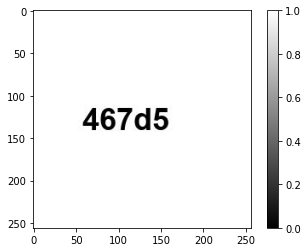

In [ ]:
def normalize(input, ouput):
  input = input/255
  ouput = ouput/255

  return input, ouput

def resize(input, ouput):
  ones_h = tf.ones([50,28,1])
  ones_v = tf.ones([103,256,1])

  input = tf.concat([ones_h,input], axis = 1)
  input = tf.concat([input,ones_h], axis = 1)
  input = tf.concat([input,ones_v], axis = 0)
  input = tf.concat([ones_v,input], axis = 0)

  ouput = tf.concat([ones_h,ouput], axis = 1)
  ouput = tf.concat([ouput,ones_h], axis = 1)
  ouput = tf.concat([ouput,ones_v], axis = 0)
  ouput = tf.concat([ones_v,ouput], axis = 0)

  return input, ouput

def load_image(filename):
  input_img = tf.cast(tf.image.decode_jpeg(tf.io.read_file(input_path + '/' + filename)), tf.float32)
  output_img = tf.cast(tf.image.decode_jpeg(tf.io.read_file(out_path + '/' + filename)), tf.float32)

  if input_img.shape[2] == 3:
    input_img =tf.image.rgb_to_grayscale(input_img)

  if output_img.shape[2] == 3:
    output_img =tf.image.rgb_to_grayscale(output_img)

  input_img, output_img = normalize(input_img, output_img)

  input_img, output_img = resize(input_img, output_img)

  return input_img, output_img

prueba, prueba1 = load_image(rand_urls[0])

plt.imshow(prueba1[:,:,0])
plt.colorbar()
plt.gray()

In [ ]:
x_train = np.ndarray((856,256,256,1))
y_train = np.ndarray((856,256,256,1))
index = 0
for i in train_urls:
  x_train[index], y_train[index] = load_image(i)
  index = index+1

In [ ]:
x_test = np.ndarray((214,256,256,1))
y_test = np.ndarray((214,256,256,1))
index = 0
for i in test_urls:  
  x_test[index], y_test[index] = load_image(i)
  index = index+1

In [ ]:
input_img = tf.keras.Input(shape=(256, 256, 1))

x = tf.keras.layers.Conv2D(64, 4, padding='same', strides = 2)(input_img)
x = tf.keras.layers.BatchNormalization()(x)
sc1 = tf.keras.layers.LeakyReLU()(x)

x = tf.keras.layers.Conv2D(128, 4, padding='same', strides = 2)(sc1)
x = tf.keras.layers.BatchNormalization()(x)
sc2 = tf.keras.layers.LeakyReLU()(x)

x = tf.keras.layers.Conv2D(256, 4, padding='same', strides = 2)(sc2)
x = tf.keras.layers.BatchNormalization()(x)
sc3 = tf.keras.layers.LeakyReLU()(x)

x = tf.keras.layers.Conv2D(512, 4, padding='same', strides = 2)(sc3)
x = tf.keras.layers.BatchNormalization()(x)
sc4 = tf.keras.layers.LeakyReLU()(x)

x = tf.keras.layers.Conv2D(512, 4, padding='same', strides = 2)(sc4)
x = tf.keras.layers.BatchNormalization()(x)
sc5 = tf.keras.layers.LeakyReLU()(x)

x = tf.keras.layers.Conv2D(512, 4, padding='same', strides = 2)(sc5)
x = tf.keras.layers.BatchNormalization()(x)
sc6 = tf.keras.layers.LeakyReLU()(x)

x = tf.keras.layers.Conv2D(512, 4, padding='same', strides = 2)(sc6)
x = tf.keras.layers.BatchNormalization()(x)
sc7 = tf.keras.layers.LeakyReLU()(x)

# middle
x = tf.keras.layers.Conv2D(512, 4, padding='same', strides = 2)(sc7)
x = tf.keras.layers.BatchNormalization()(x)
sc8 = tf.keras.layers.LeakyReLU()(x)

#
x = tf.keras.layers.Conv2DTranspose(512, 4, padding='same', strides = 2)(sc8)
x = tf.concat([x,sc7], axis=3)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Conv2DTranspose(512, 4, padding='same', strides = 2)(x)
x = tf.concat([x,sc6], axis=3)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Conv2DTranspose(512, 4, padding='same', strides = 2)(x)
x = tf.concat([x,sc5], axis=3)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Conv2DTranspose(512, 4, padding='same', strides = 2)(x)
x = tf.concat([x,sc4], axis=3)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)

x = tf.keras.layers.Conv2DTranspose(256, 4, padding='same', strides = 2)(x)
x = tf.concat([x,sc3], axis=3)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)

x = tf.keras.layers.Conv2DTranspose(128, 4, padding='same', strides = 2)(x)
x = tf.concat([x,sc2], axis=3)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)

x = tf.keras.layers.Conv2DTranspose(64, 4, padding='same', strides = 2)(x)
x = tf.concat([x,sc1], axis=3)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)


output = tf.keras.layers.Conv2DTranspose(1, 4, padding='same', activation = "tanh", strides = 2)(x)

model_unet = tf.keras.Model(input_img, output)
model_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1088        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
learning_rate= 2e-4
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model_unet.compile(optimizer=opt, loss='mean_squared_error', metrics=[PSNR_train,ssim_train])

start_time = time.time()

history = model_unet.fit(x_train, y_train, epochs=50, verbose=1, batch_size=32, validation_data=(x_test, y_test))

print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/50
27/27 [==============================] - 92s 3s/step - loss: 0.4408 - PSNR_train: 4.2573 - ssim_train: 0.2236 - val_loss: 0.7481 - val_PSNR_train: 1.2604 - val_ssim_train: 0.0808
Epoch 2/50
27/27 [==============================] - 57s 2s/step - loss: 0.0822 - PSNR_train: 11.1843 - ssim_train: 0.6008 - val_loss: 0.6677 - val_PSNR_train: 1.7541 - val_ssim_train: 0.0696
Epoch 3/50
27/27 [==============================] - 57s 2s/step - loss: 0.0287 - PSNR_train: 15.5392 - ssim_train: 0.7943 - val_loss: 0.1943 - val_PSNR_train: 7.1156 - val_ssim_train: 0.3579
Epoch 4/50
27/27 [==============================] - 57s 2s/step - loss: 0.0174 - PSNR_train: 17.6158 - ssim_train: 0.8699 - val_loss: 0.0682 - val_PSNR_train: 11.6606 - val_ssim_train: 0.6569
Epoch 5/50
27/27 [==============================] - 57s 2s/step - loss: 0.0137 - PSNR_train: 18.6398 - ssim_train: 0.9036 - val_loss: 0.0448 - val_PSNR_train: 13.4854 - val_ssim_train: 0.7300
Epoch 6/50
27/27 [==========================

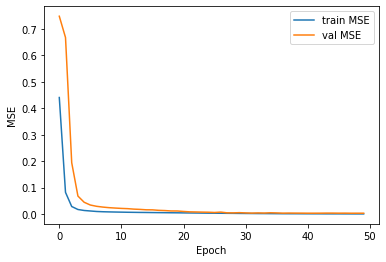

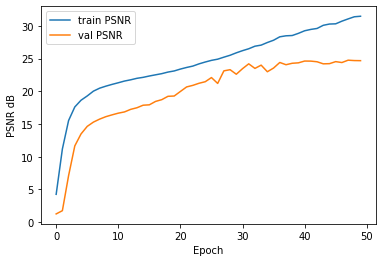

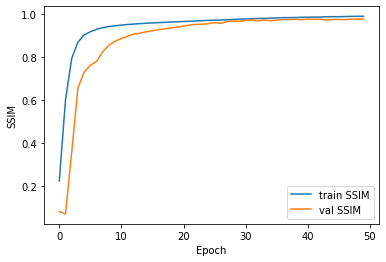

In [ ]:
plt.plot(history.history['loss'], label='train MSE')
plt.plot(history.history['val_loss'], label='val MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()
plt.plot(history.history['PSNR_train'], label='train PSNR')
plt.plot(history.history['val_PSNR_train'], label='val PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR dB')
plt.legend()
plt.show()
plt.plot(history.history['ssim_train'], label='train SSIM')
plt.plot(history.history['val_ssim_train'], label='val SSIM')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.legend()
plt.show()

In [ ]:
model_unet.save('/content/drive/MyDrive/course-IA2/Proyecto/models/u_net.h5')

In [ ]:
predict_unet = model_unet.predict(x_test)

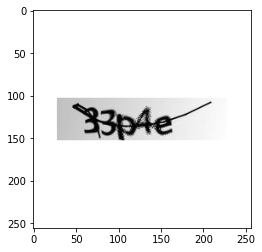

In [ ]:
plt.imshow(x_test[0,:,:,0])

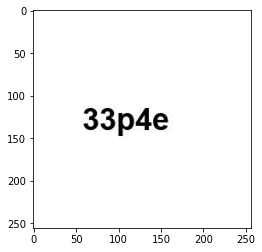

In [ ]:
plt.imshow(y_test[0,:,:,0])

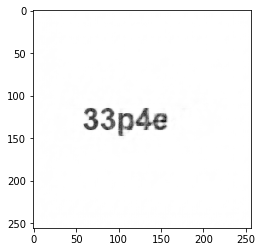

In [ ]:
plt.imshow(predict_unet[0,:,:,0])

In [ ]:
%cd '/content/drive/MyDrive/course-IA2/Proyecto/predict'
with open('predict_unet.npy', 'wb') as q:
    np.save(q, predict_unet)

/content/drive/MyDrive/course-IA2/Proyecto/predict


In [ ]:
input_img = tf.keras.Input(shape=(256, 256, 1))

x = tf.keras.layers.Conv2D(64, 4, padding='same', strides = 2)(input_img)
x = tf.keras.layers.BatchNormalization()(x)
sc1 = tf.keras.layers.LeakyReLU()(x)

x = tf.keras.layers.Conv2D(128, 4, padding='same', strides = 2)(sc1)
x = tf.keras.layers.BatchNormalization()(x)
sc2 = tf.keras.layers.LeakyReLU()(x)

x = tf.keras.layers.Conv2D(256, 4, padding='same', strides = 2)(sc2)
x = tf.keras.layers.BatchNormalization()(x)
sc3 = tf.keras.layers.LeakyReLU()(x)

x = tf.keras.layers.Conv2D(512, 4, padding='same', strides = 2)(sc3)
x = tf.keras.layers.BatchNormalization()(x)
sc4 = tf.keras.layers.LeakyReLU()(x)

x = tf.keras.layers.Conv2D(512, 4, padding='same', strides = 2)(sc4)
x = tf.keras.layers.BatchNormalization()(x)
sc5 = tf.keras.layers.LeakyReLU()(x)

x = tf.keras.layers.Conv2D(512, 4, padding='same', strides = 2)(sc5)
x = tf.keras.layers.BatchNormalization()(x)
sc6 = tf.keras.layers.LeakyReLU()(x)

x = tf.keras.layers.Conv2D(512, 4, padding='same', strides = 2)(sc6)
x = tf.keras.layers.BatchNormalization()(x)
sc7 = tf.keras.layers.LeakyReLU()(x)

# middle
x = tf.keras.layers.Conv2D(512, 4, padding='same', strides = 2)(sc7)
x = tf.keras.layers.BatchNormalization()(x)
sc8 = tf.keras.layers.LeakyReLU()(x)

#
x = tf.keras.layers.Conv2DTranspose(512, 4, padding='same', strides = 2)(sc8)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Conv2DTranspose(512, 4, padding='same', strides = 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Conv2DTranspose(512, 4, padding='same', strides = 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Conv2DTranspose(512, 4, padding='same', strides = 2)(x)
x = tf.concat([x,sc4], axis=3)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)

x = tf.keras.layers.Conv2DTranspose(256, 4, padding='same', strides = 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)

x = tf.keras.layers.Conv2DTranspose(128, 4, padding='same', strides = 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)

x = tf.keras.layers.Conv2DTranspose(64, 4, padding='same', strides = 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)

output = tf.keras.layers.Conv2DTranspose(1, 4, padding='same', activation = "tanh", strides = 2)(x)

model_autoencoder = tf.keras.Model(input_img, output)
model_autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 128, 128, 64  1088        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_15 (BatchN  (None, 128, 128, 64  256        ['conv2d_8[0][0]']               
 ormalization)                  )                                                           

In [ ]:
learning_rate= 2e-4
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model_autoencoder.compile(optimizer=opt, loss='mean_squared_error', metrics=[PSNR_train,ssim_train])

start_time = time.time()

history1 = model_autoencoder.fit(x_train, y_train, epochs=50, verbose=1, batch_size=32, validation_data=(x_test, y_test))

print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/50
27/27 [==============================] - 54s 2s/step - loss: 0.4787 - PSNR_train: 3.6690 - ssim_train: 0.2307 - val_loss: 0.7647 - val_PSNR_train: 1.1650 - val_ssim_train: 0.1741
Epoch 2/50
27/27 [==============================] - 43s 2s/step - loss: 0.1818 - PSNR_train: 7.5109 - ssim_train: 0.5379 - val_loss: 1.6457 - val_PSNR_train: -2.1635 - val_ssim_train: 0.0012
Epoch 3/50
27/27 [==============================] - 43s 2s/step - loss: 0.0870 - PSNR_train: 10.6828 - ssim_train: 0.5730 - val_loss: 1.0923 - val_PSNR_train: -0.3834 - val_ssim_train: 0.0304
Epoch 4/50
27/27 [==============================] - 43s 2s/step - loss: 0.0508 - PSNR_train: 12.9888 - ssim_train: 0.7008 - val_loss: 0.2170 - val_PSNR_train: 6.6351 - val_ssim_train: 0.5829
Epoch 5/50
27/27 [==============================] - 43s 2s/step - loss: 0.0307 - PSNR_train: 15.1783 - ssim_train: 0.7700 - val_loss: 0.1093 - val_PSNR_train: 9.6155 - val_ssim_train: 0.5132
Epoch 6/50
27/27 [===========================

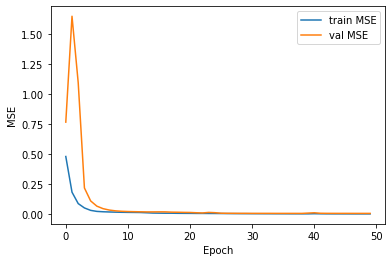

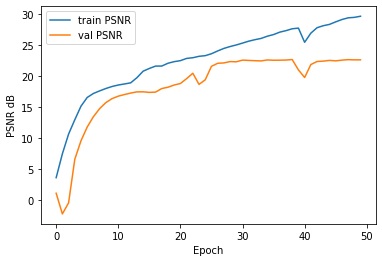

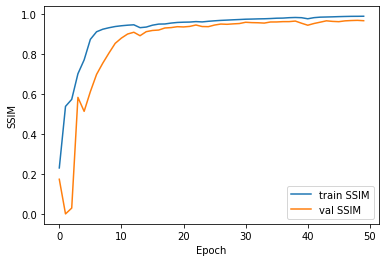

In [ ]:
plt.plot(history1.history['loss'], label='train MSE')
plt.plot(history1.history['val_loss'], label='val MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()
plt.plot(history1.history['PSNR_train'], label='train PSNR')
plt.plot(history1.history['val_PSNR_train'], label='val PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR dB')
plt.legend()
plt.show()
plt.plot(history1.history['ssim_train'], label='train SSIM')
plt.plot(history1.history['val_ssim_train'], label='val SSIM')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.legend()
plt.show()

In [ ]:
model_autoencoder.save('/content/drive/MyDrive/course-IA2/Proyecto/models/autoencoder.h5')

In [ ]:
predict_autoencoder = model_autoencoder.predict(x_test)

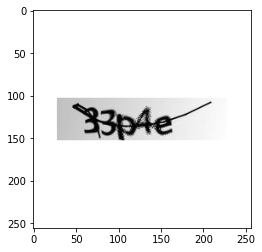

In [ ]:
plt.imshow(x_test[0,:,:,0])

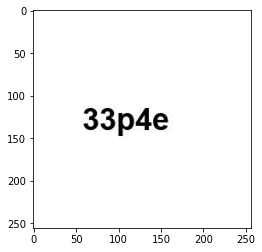

In [ ]:
plt.imshow(y_test[0,:,:,0])

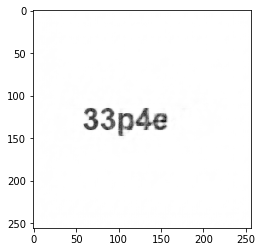

In [ ]:
plt.imshow(predict_unet[0,:,:,0])

In [ ]:
%cd '/content/drive/MyDrive/course-IA2/Proyecto/predict'
with open('predict_autoencoder.npy', 'wb') as q:
    np.save(q, predict_autoencoder)

/content/drive/MyDrive/course-IA2/Proyecto/predict
